### Install bgfc_kit package from github 

In [30]:
!pip install git+https://github.com/peetal/bgfc_kit.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/peetal/bgfc_kit.git to /tmp/pip-req-build-3fa7k3g8
  Running command git clone -q https://github.com/peetal/bgfc_kit.git /tmp/pip-req-build-3fa7k3g8
  Resolved https://github.com/peetal/bgfc_kit.git to commit e3df737c204ef0c9f97a28fa028a69b1322dcc23
  Preparing metadata (setup.py) ... done
  Created wheel for bgfc-kit: filename=bgfc_kit-1.0.0-py3-none-any.whl size=15210 sha256=d15799d317a25f8ec2e64b93562f52464cc900a4711a5d0e30a2043f08455e3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1l2qryw/wheels/c2/43/f7/5eb8e554d07e831c44f50baa607c3cd385b76616ad17275a69
Successfully built bgfc-kit


In [6]:
import bgfc_kit
bgfc_kit

<module 'bgfc_kit' from '/home/peetal/.local/lib/python3.9/site-packages/bgfc_kit/__init__.py'>

## 1. Finite impulse model (FIR) design matrix 

In [13]:
from bgfc_kit.fir_design_matrix import generate_FIRdesignMat_template_toml
generate_FIRdesignMat_template_toml

<function bgfc_kit.fir_design_matrix.generate_FIRdesignMat_template_toml(output_dir: str)>

#### 1.1 Creating configuration file template
- Generating the FIR model design matrix needs many specific inforamtion about the task design. These information can be too chunky to include in a single function. 
- So you can first create an empty configuration file with all necessary parameters to generate the design matrix. After you fill it out, it can be reused to generate FIR model design matrices easily.

In [14]:
# generate an the template configuratio file
output_dir = '/projects/hulacon/peetal/bgfc_kit_test/'
generate_FIRdesignMat_template_toml(output_dir)

Let's have a quick look at the configuration file template
- The `PARAMETERS` are empty and will take your inputs that are specific to your experiment design. 
- The `COMMENTS` explains what each parameter is.

In [38]:
import os, toml
with open(os.path.join(output_dir, 'FIRdesignMat_conf.toml'), 'r') as file:
    data = toml.load(file)
print(f"The required parameters are {list(data['PARAMETERS'].keys())}")

The required parameters are ['conditions', 'rep', 'fir_regressors', 'epoch_tr', 'run_leadingin_tr', 'run_leadingout_tr', 'epoch_per_run', 'fmriprep_dir', 'fd_cutoff', 'spike_cutoff', 'prop_spike_cutoff', 'sub_id', 'order']


#### 1.2 Generating FIR model design matrix for a subject 
- The `write_personalized_FIRdesignMat` takes account of excessive motion and remove bad frame or runs (such as the last run in the current case. 
- Simpler version `write_vanilla_FIRdesignMat` can be used if no need to consider motions.

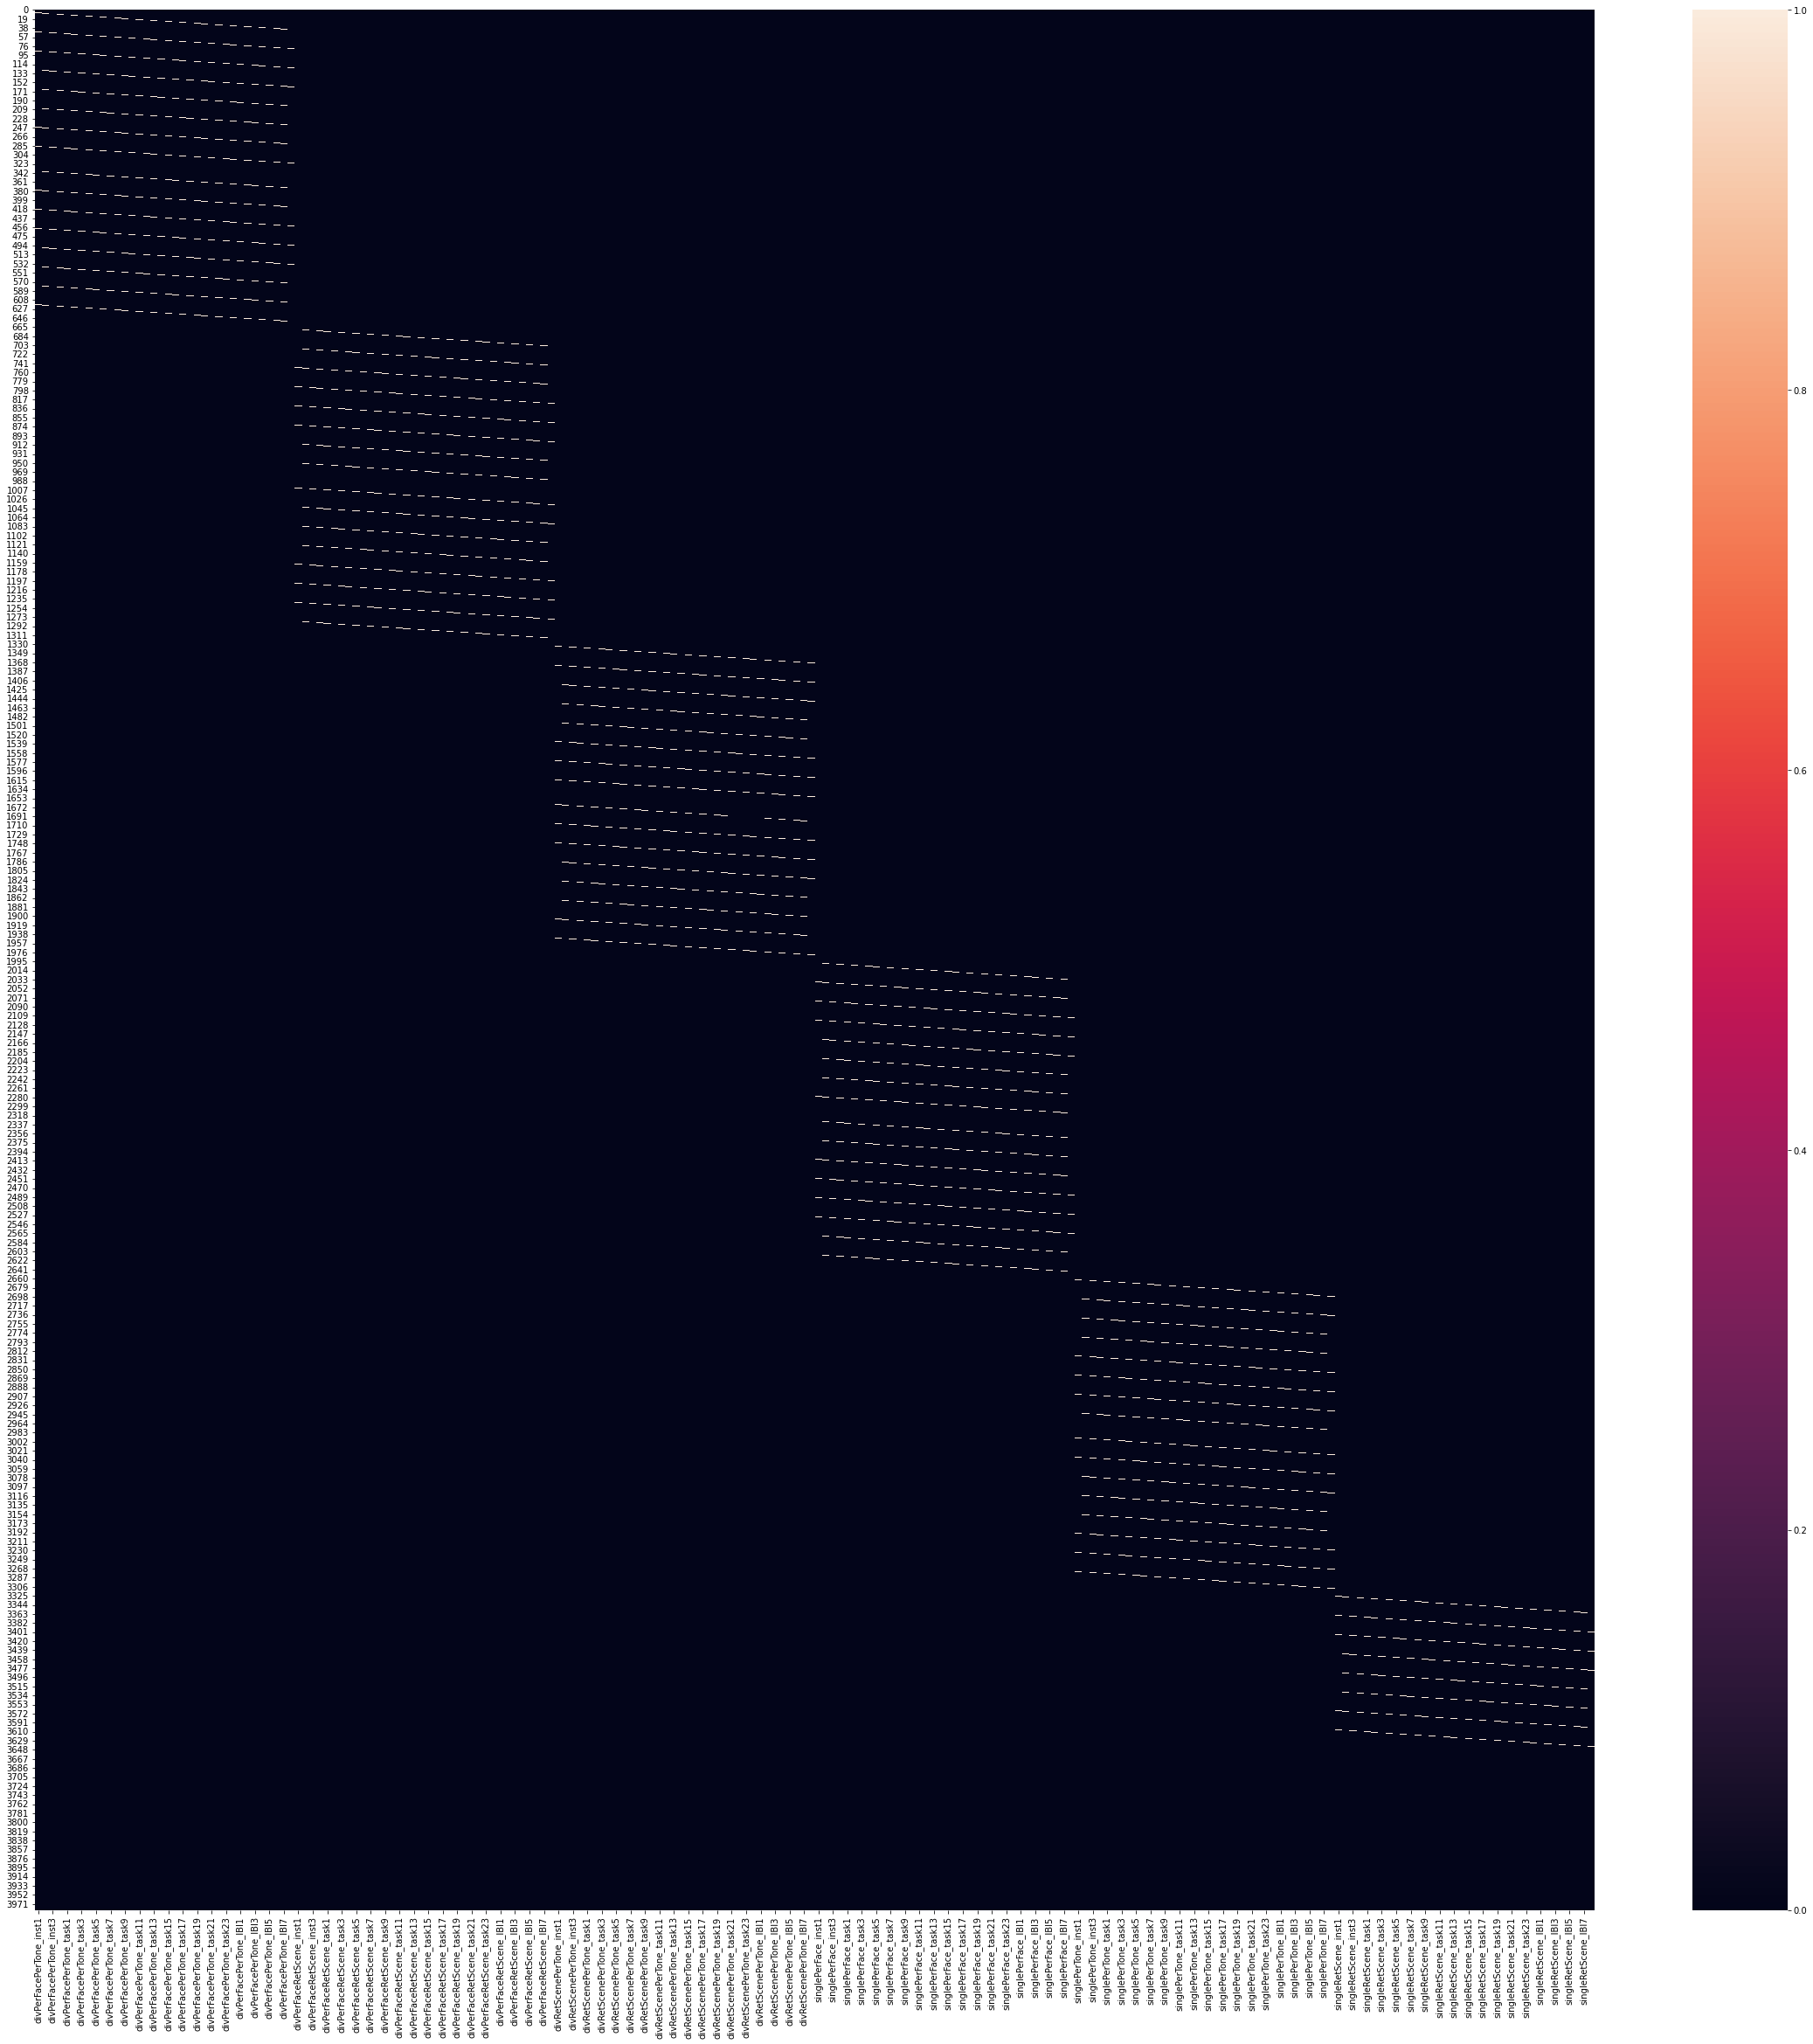

In [40]:
from bgfc_kit.fir_design_matrix import write_personalized_FIRdesginMat
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
write_personalized_FIRdesginMat(cfg_dir, output_dir)

## 2. BGFC preprocessing pipeline

- STEPS:
1. Spatial smoothing: niflow.fmri.fsl.create_susan_smooth
2. High-pass filtering: fsl.MeanImage; fsl.ImageMaths
3. Intensity normalization: fsl.ImageStats; fsl.ImageMaths
4. Skull strip: fsl.Applymask 
5. Nuisance GLM: FEAT implemented using nipype
6. Concatenation and Demean to obtain full timeseries: User defined function
7. FIR GLM: fsl.GLM 
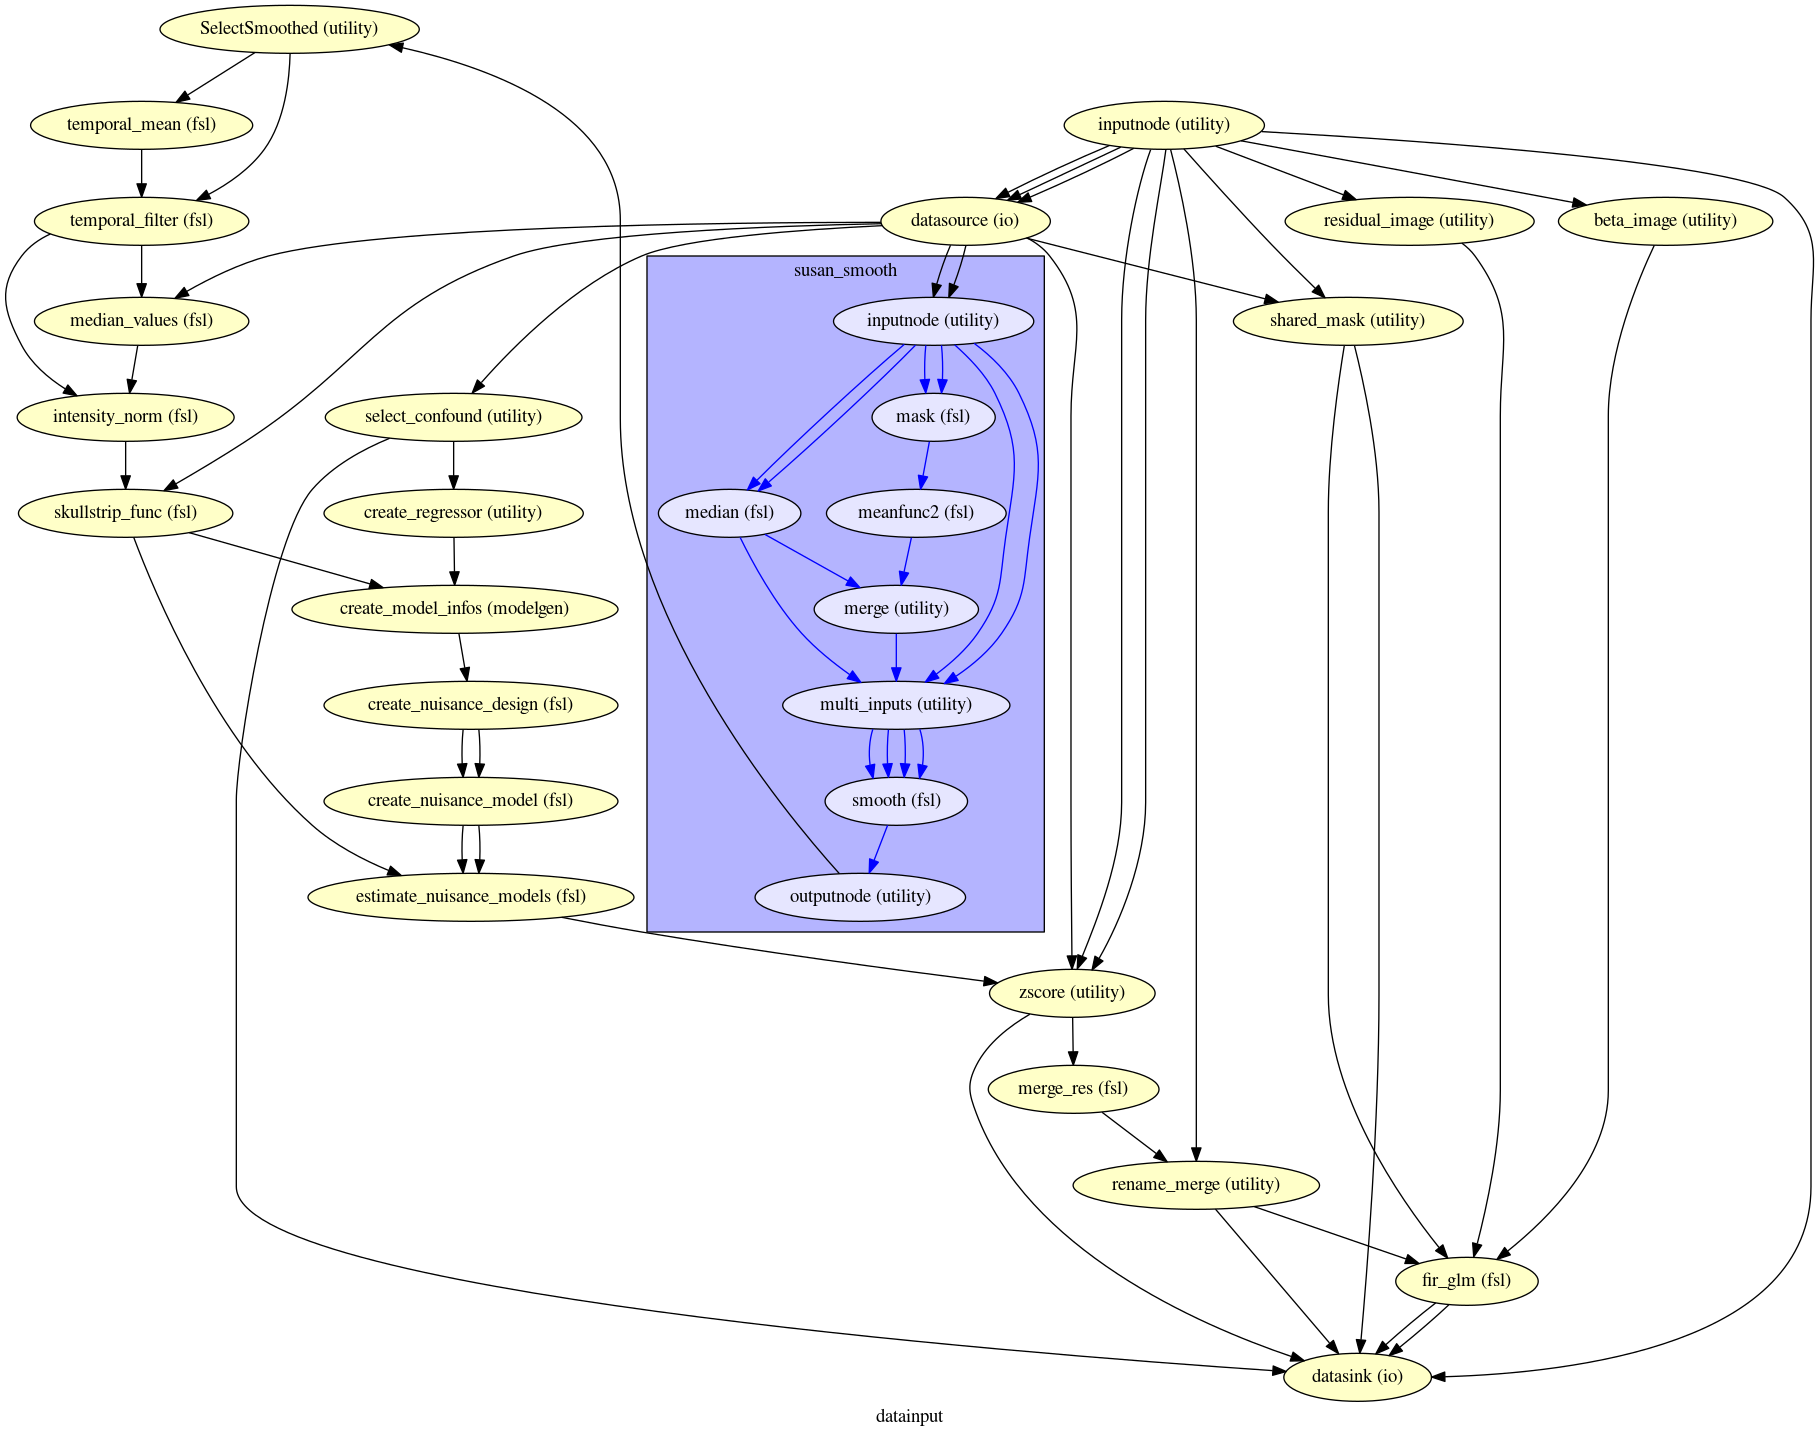

- OUTPUTs: 
1. Concatenated timeseries after nuisance but before FIR GLM. 
2. Beta values from FIR GLM. 
3. Concatenated (residual) timeseries after FIR GLM. 

#### 2.1 Creating configuration file template

In [43]:
from bgfc_kit.preprocessing_pipeline import generate_postfMRIprep_pipeline_template_toml
generate_postfMRIprep_pipeline_template_toml(output_dir)

#### 2.2 Submit SLURM job to talapas

- This feature is specifically useful for talapas users. the `submit_postfMRIprep_pipeline_SLURM` function will write out a shell script and submit a slurm job automatically through subprocess. 

In [2]:
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
shell_dir = '/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh'
submit_postfMRIprep_pipeline_SLURM(cfg_dir, shell_dir, "hulacon", "fat", "post_fmriprep", "100GB")

Bash script submitted successfully.
Job ID: Submitted batch job 29548876


In [44]:
with open('/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh', 'r') as file:
    script_content = file.read()

# Print the content of the shell script
print(script_content)

#!/bin/bash
#SBATCH --account=hulacon
#SBATCH --partition=fat  
#SBATCH --job-name=post_fmriprep  
#SBATCH --mem=100GB
#SBATCH --time=1-00:00:00
#SBATCH --output=%x_%A_%a.log

module load fsl
module load ants
module load miniconda
module load singularity
conda activate jupyterlab-tf-pyt-20211020

python3 /gpfs/projects/hulacon/peetal/bgfc_kit/bgfc_kit/scripts/post_fMRIPrep_pipeline.py --sub-id 001 --task-id divPerFacePerTone_run-1 divPerFacePerTone_run-2 divPerFaceRetScene_run-1 divPerFaceRetScene_run-2 divRetScenePerTone_run-1 divRetScenePerTone_run-2 singlePerFace_run-1 singlePerFace_run-2 singlePerTone_run-1 singlePerTone_run-2 singleRetScene_run-1 singleRetScene_run-2  --space T1w --base-dir /projects/hulacon/peetal/divatten --output-dir /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data --designMat-dir /projects/hulacon/peetal/bgfc_kit_test/fir_design_matrix.txt --run-restTR 38 39 40 41 42 43 44 45 46 47 48 49 78 79 80 81 82 83 84 85 86 87 88 89 118 119 120 121 122 123 124 1

In [45]:
!tree /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001

/projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001
|-- FIR_betas
|   `-- sub-001_beta216.nii.gz
|-- FIR_residual
|   `-- sub-001_res3984.nii.gz
|-- before_FIR
|   `-- sub-001_nuisanceRES_CONCAT.nii.gz
|-- nuisance_regressor
|   |-- sub-001_task-divPerFacePerTone_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divPerFacePerTone_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divPerFaceRetScene_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divPerFaceRetScene_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divRetScenePerTone_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divRetScenePerTone_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-singlePerFace_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-singlePerFace_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-singlePerTone_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-00